In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import holidays

In [2]:
sns.set_theme()

In [3]:
df = pd.read_parquet('../data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)
df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(int).astype(str) + ':00:00')
df.drop(columns='fecha', inplace=True)
df.set_index('datetime', inplace=True)
df.head()

,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana,holiday
datetime,,,,,,,,,,,,,,,
2023-11-01 00:00:00,0.0,8.6725,0.0,60.153034,0.0,3,12,2196,232,1,2023,11,1,3,0
2023-11-01 01:00:00,1.0,8.5725,0.1,60.344471,0.0,2,12,1521,55,0,2023,11,1,3,0
2023-11-01 02:00:00,2.0,8.3225,0.0,62.933163,0.0,3,8,1214,16,0,2023,11,1,3,0
2023-11-01 03:00:00,3.0,8.0725,0.1,66.100021,0.0,0,13,854,20,0,2023,11,1,3,0
2023-11-01 04:00:00,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3,0


In [4]:
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

Probamos inicialmente con Manhattan:

In [8]:
# Crear un dataset LightGBM
X_train, X_test, y_train, y_test = train_test_split(X, Y['Manhattan'], test_size=0.2, random_state=42, shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'regression',  # Tipo de objetivo: regresión
    'metric': 'rmse',  # Métrica de evaluación: RMSE (Root Mean Squared Error)
    'boosting': 'gbdt',  # Tipo de algoritmo de boosting: Gradient Boosting Decision Tree
    'learning_rate': 0.05,  # Tasa de aprendizaje
    'num_leaves': 31,  # Número máximo de hojas por árbol
    'feature_fraction': 0.8,  # Proporción de características a considerar en cada árbol
    'bagging_fraction': 0.8,  # Proporción de datos de entrenamiento a considerar en cada iteración
    'bagging_freq': 5,  # Frecuencia de uso de bagging
    'num_boost_round': 1000,  # Número de rondas de boosting
    'verbose': 0  # Nivel de detalle de los mensajes (0: silencioso, 1: normal, >1: verbose)
}

# Entrenar el modelo
model = lgb.train(params, train_data, valid_sets=[test_data])

# Realizar predicciones en el set de prueba
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calcular el RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 1438.7939479991421


Vemos nuevamente que se obtiene un excelente RMSE sin hacer ningún tipo de optimización de parámetros.

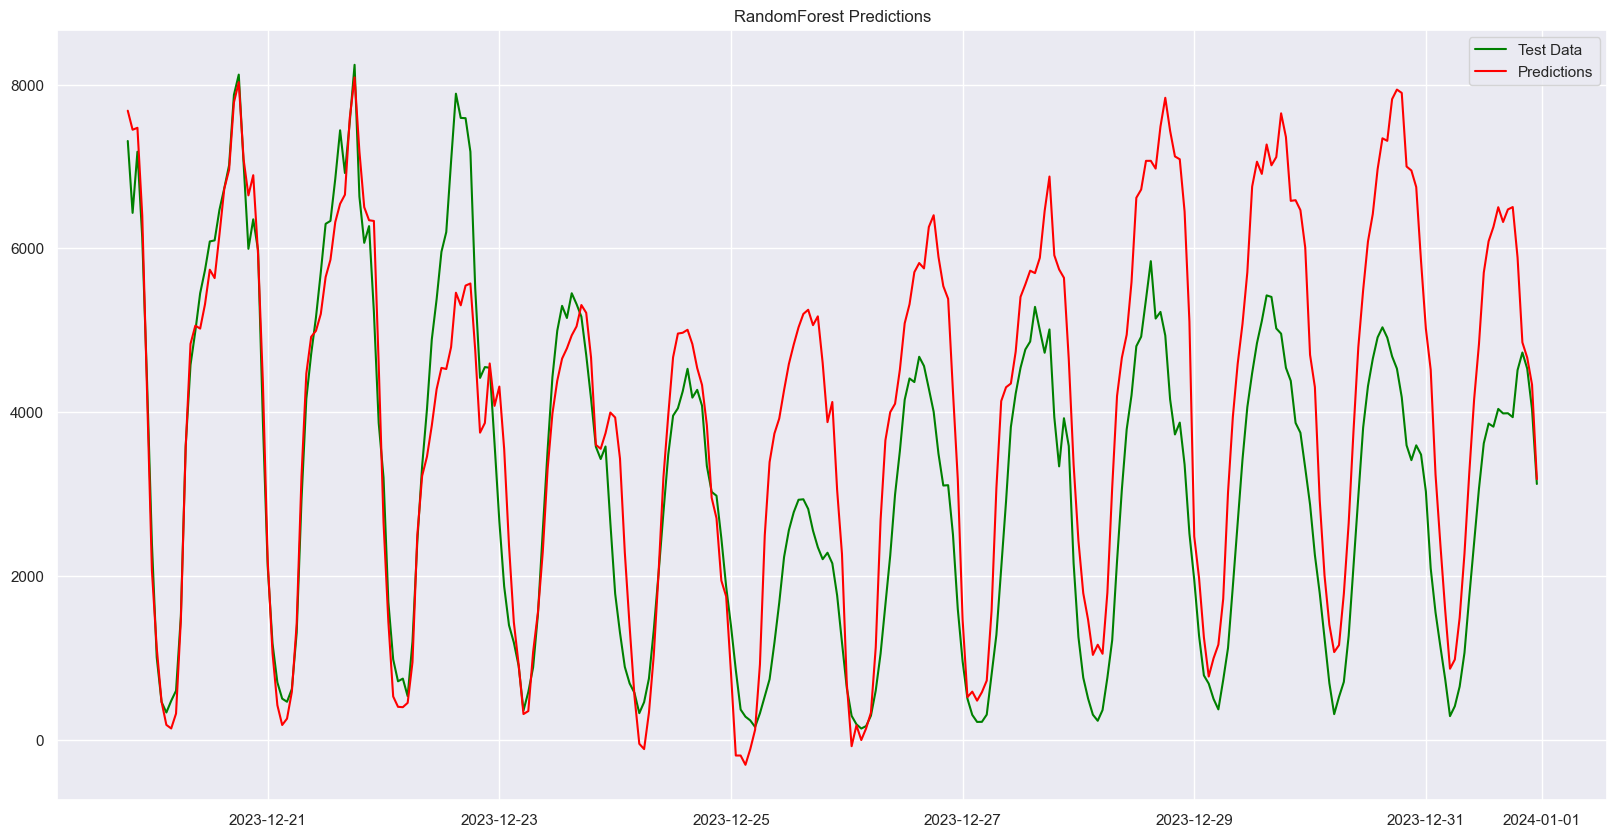

In [9]:
y_pred = pd.Series(data=y_pred, index=y_test.index)
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Test Data', color='green')
plt.plot(y_pred, label='Predictions', color='red')
plt.title('RandomForest Predictions')
plt.legend()
plt.show()

Veamos la importancia de las features:

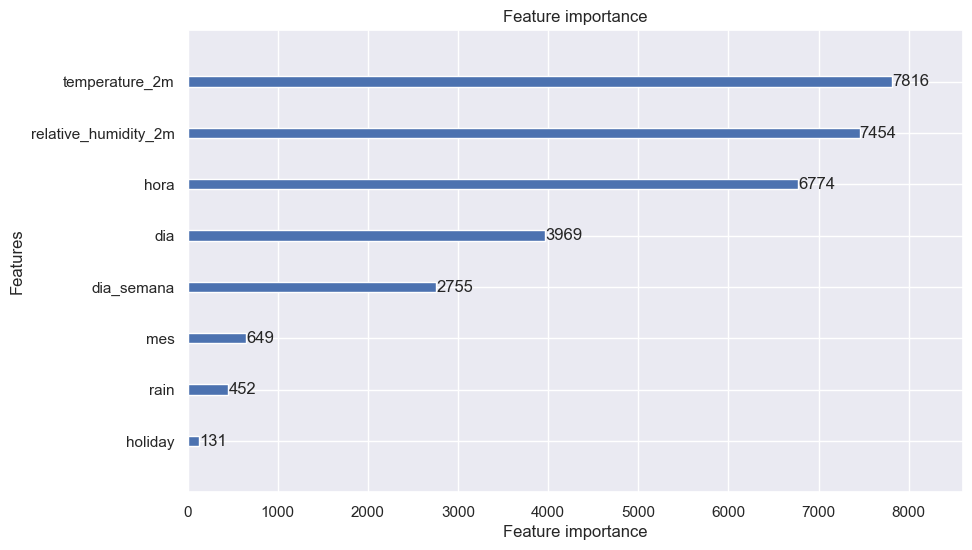

In [10]:
lgb.plot_importance(model, figsize=(10, 6), max_num_features=10)  # Graficar las 10 características más importantes
plt.show()

Modularicemos todo:

In [11]:
def generar_modelos(df):

    columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
    X = df[columnas_X]

    columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
    Y = df[columnas_Y]

    models = {}
    predictions = {}
    errors = {}

    for district in columnas_Y:
        print('Inicio de evaluación de', district)
        X_train, X_test, y_train, y_test = train_test_split(X, Y[district], test_size=0.2, random_state=42, shuffle=False)

        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)

        # Definir los parámetros del modelo
        params = {
            'objective': 'regression',  # Tipo de objetivo: regresión
            'metric': 'rmse',  # Métrica de evaluación: RMSE (Root Mean Squared Error)
            'boosting': 'gbdt',  # Tipo de algoritmo de boosting: Gradient Boosting Decision Tree
            'learning_rate': 0.05,  # Tasa de aprendizaje
            'num_leaves': 31,  # Número máximo de hojas por árbol
            'feature_fraction': 0.8,  # Proporción de características a considerar en cada árbol
            'bagging_fraction': 0.8,  # Proporción de datos de entrenamiento a considerar en cada iteración
            'bagging_freq': 5,  # Frecuencia de uso de bagging
            'num_boost_round': 1000,  # Número de rondas de boosting
            'verbose': 0  # Nivel de detalle de los mensajes (0: silencioso, 1: normal, >1: verbose)
        }

        # Entrenar el modelo
        model = lgb.train(params, train_data, valid_sets=[test_data])
        
        models[district] = model
        # Predecir los datos de prueba
        y_pred = model.predict(X_test)

        # Evaluar el modelo
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        errors[district] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

        print('RMSE:', rmse)

        predictions_df = pd.DataFrame({
        'Predicted': y_pred,
        'Real values': y_test
        }, index=y_test.index )

        predictions[district] = predictions_df
        
        print('-----------------------------------------------------------------------------------------')
    return models, predictions, errors

In [12]:
def graficar_predicciones(predictions):
    for district, data in predictions.items():
        plt.figure(figsize=(20, 10))
        plt.plot(data['Real values'], label='Test Data', color='green')
        plt.plot(data['Predicted'], label='Predictions', color='red')
        plt.legend()
        plt.title(f'RandomForest Predictions for {district}')
        plt.xlabel('Date')
        plt.ylabel('Demand')
        plt.show()

In [13]:
def graficar_importancias(models, features= ['año', 'mes', 'dia', 'hora', 'dia_semana', 
                                             'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']):
    
    for district, model in models.items():
        
        plt.figure(figsize=(5, 5))
        lgb.plot_importance(model, figsize=(10, 6), max_num_features=10)  # Graficar las 10 características más importantes
        plt.title(f'Feature Importances in {district}')
        plt.show()

In [14]:
models, predictions, errors = generar_modelos(df)

Inicio de evaluación de Bronx
RMSE: 6.799804688417477
-----------------------------------------------------------------------------------------
Inicio de evaluación de Brooklyn
RMSE: 25.557546951794077
-----------------------------------------------------------------------------------------
Inicio de evaluación de Manhattan
RMSE: 1438.7939479991421
-----------------------------------------------------------------------------------------
Inicio de evaluación de Queens
RMSE: 135.45064948737812
-----------------------------------------------------------------------------------------
Inicio de evaluación de Staten Island
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 0.3798747406816025
-----------------------------------------------------------------------------------------


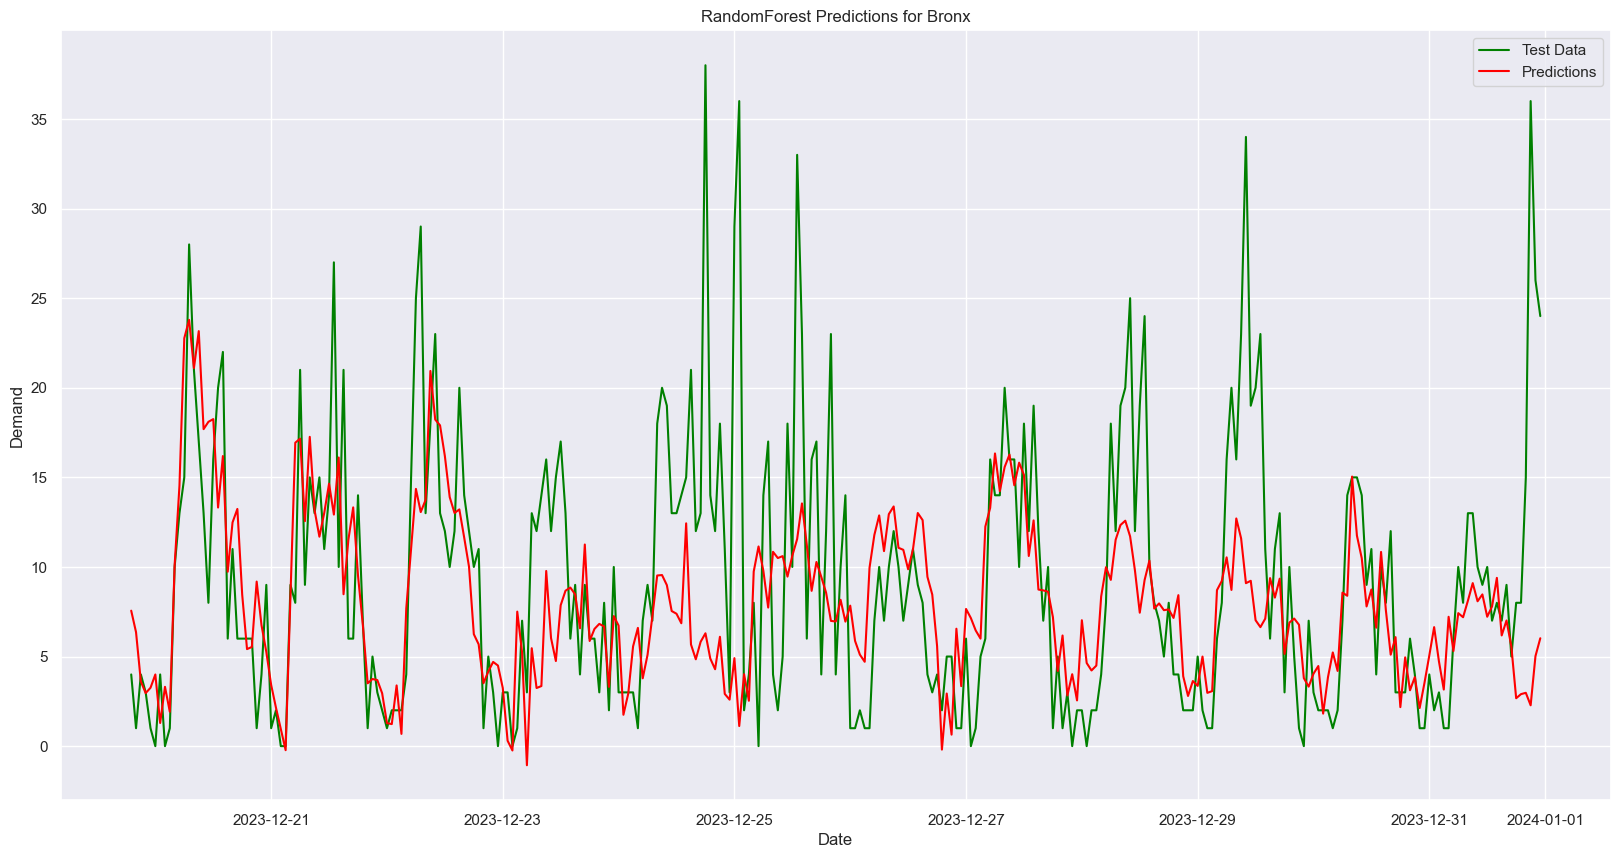

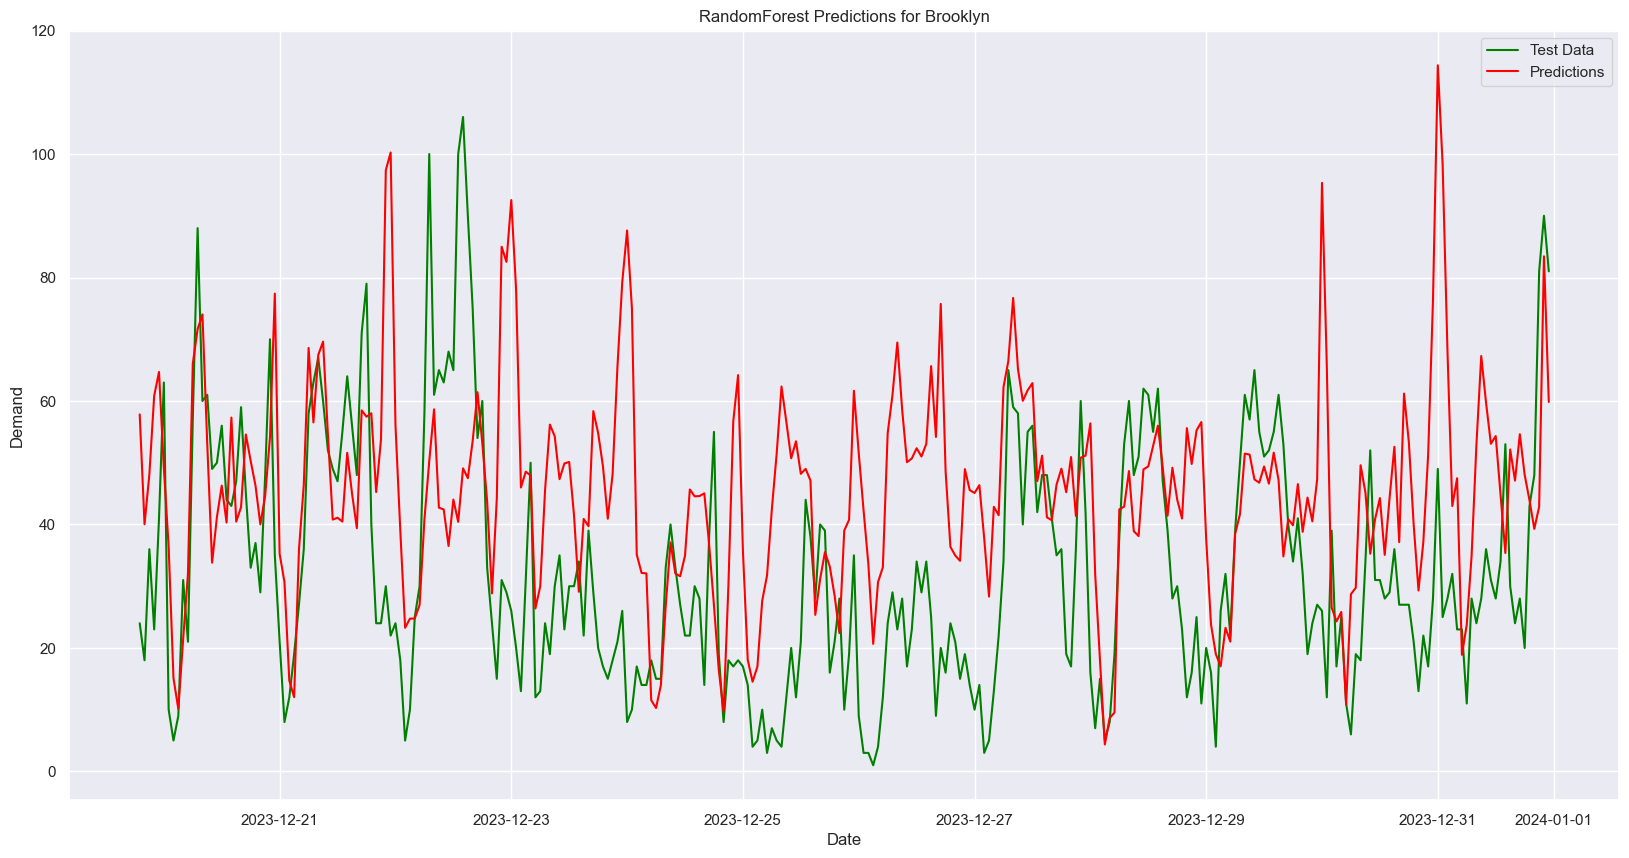

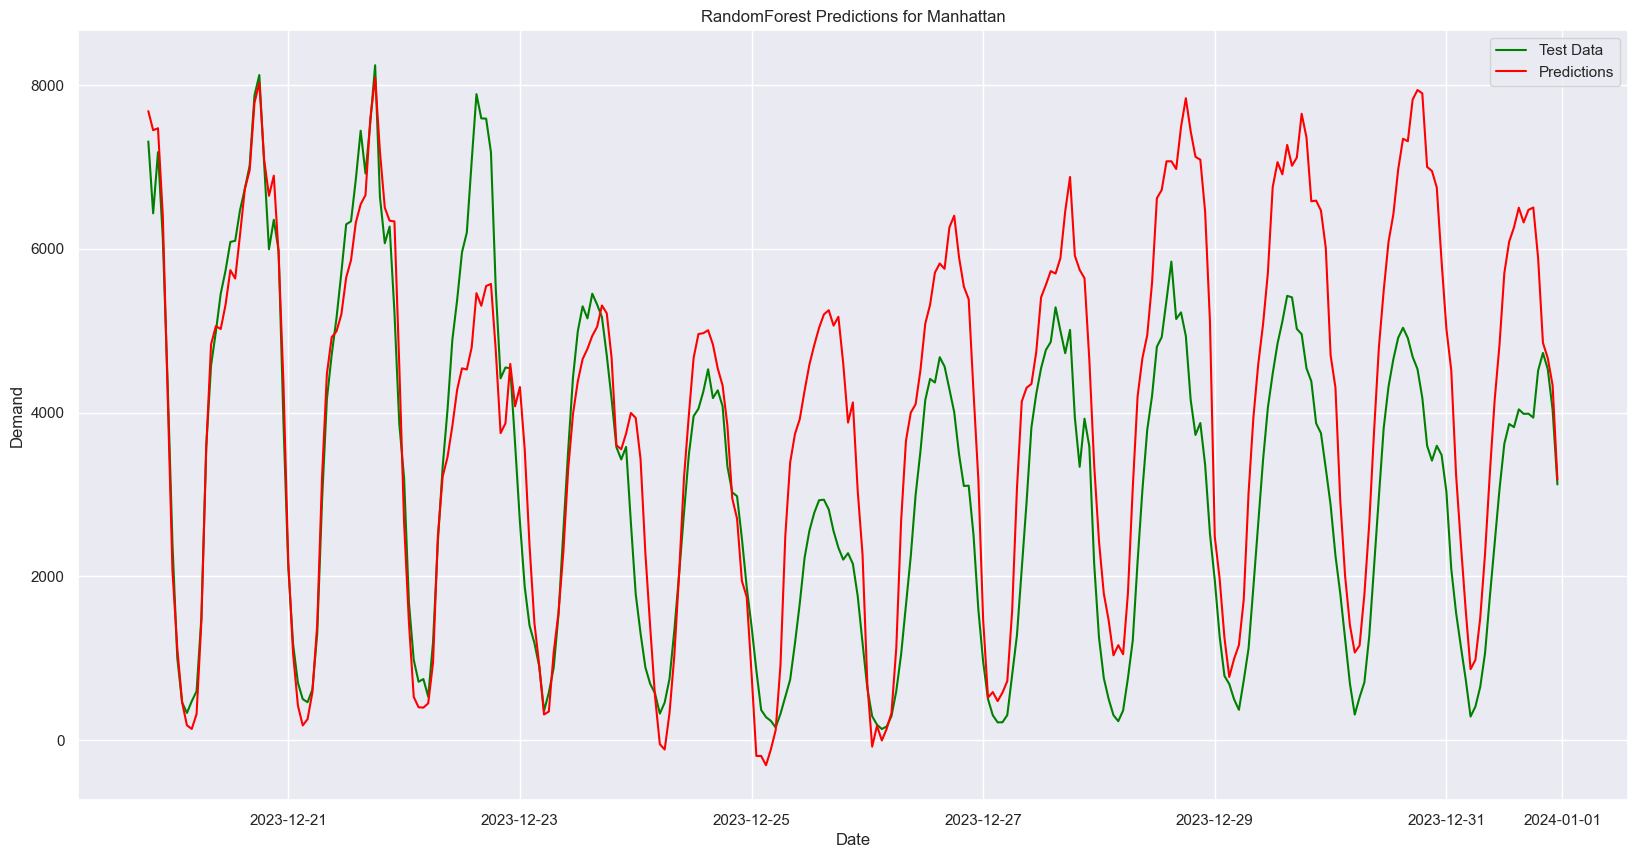

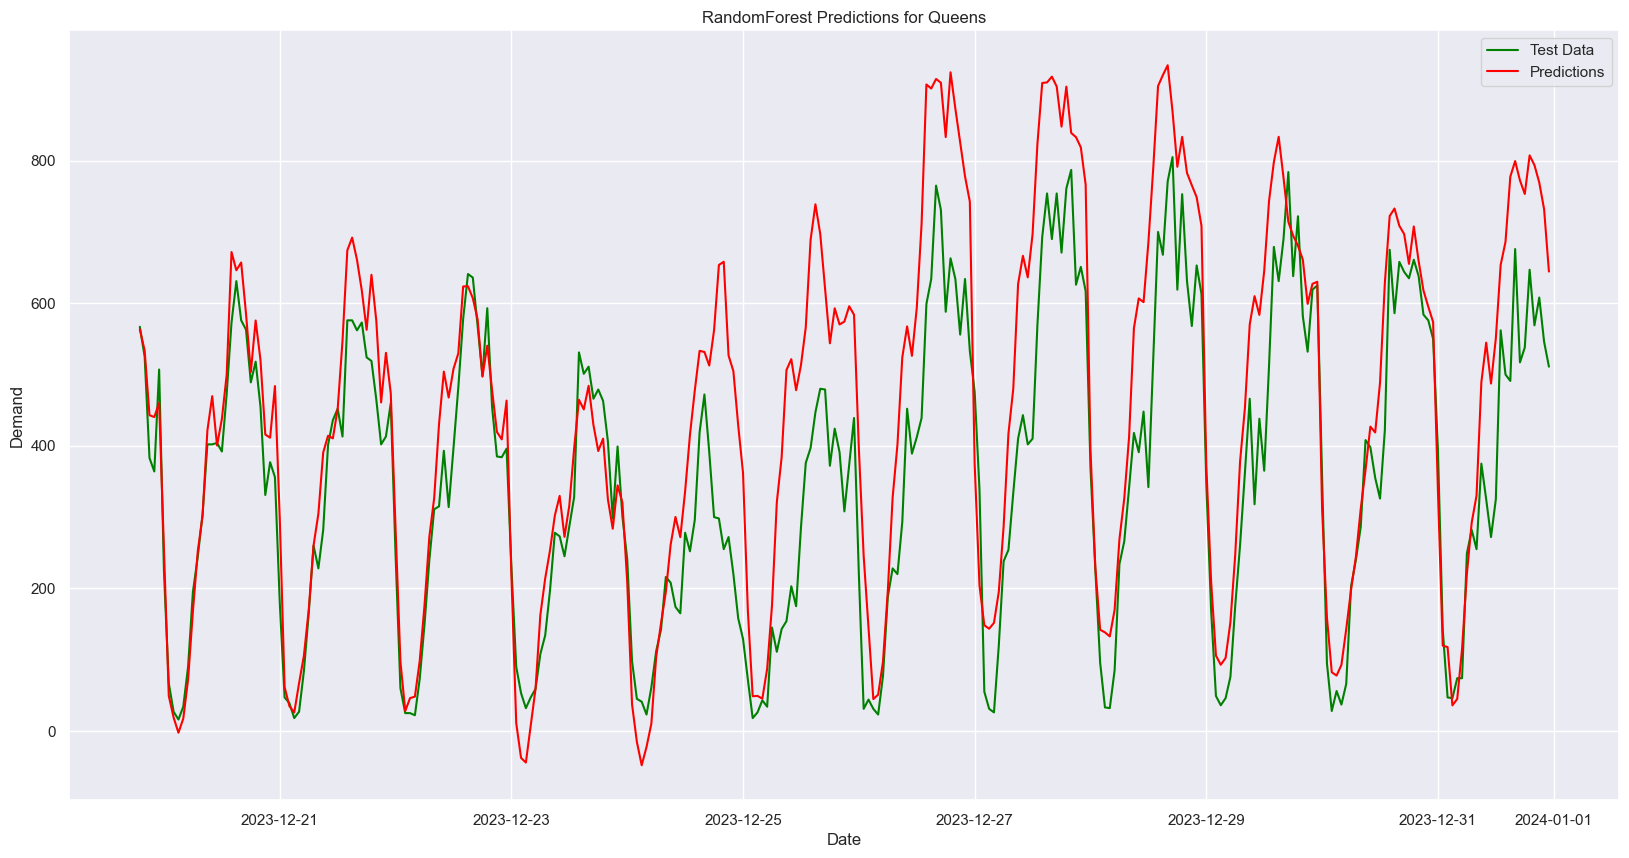

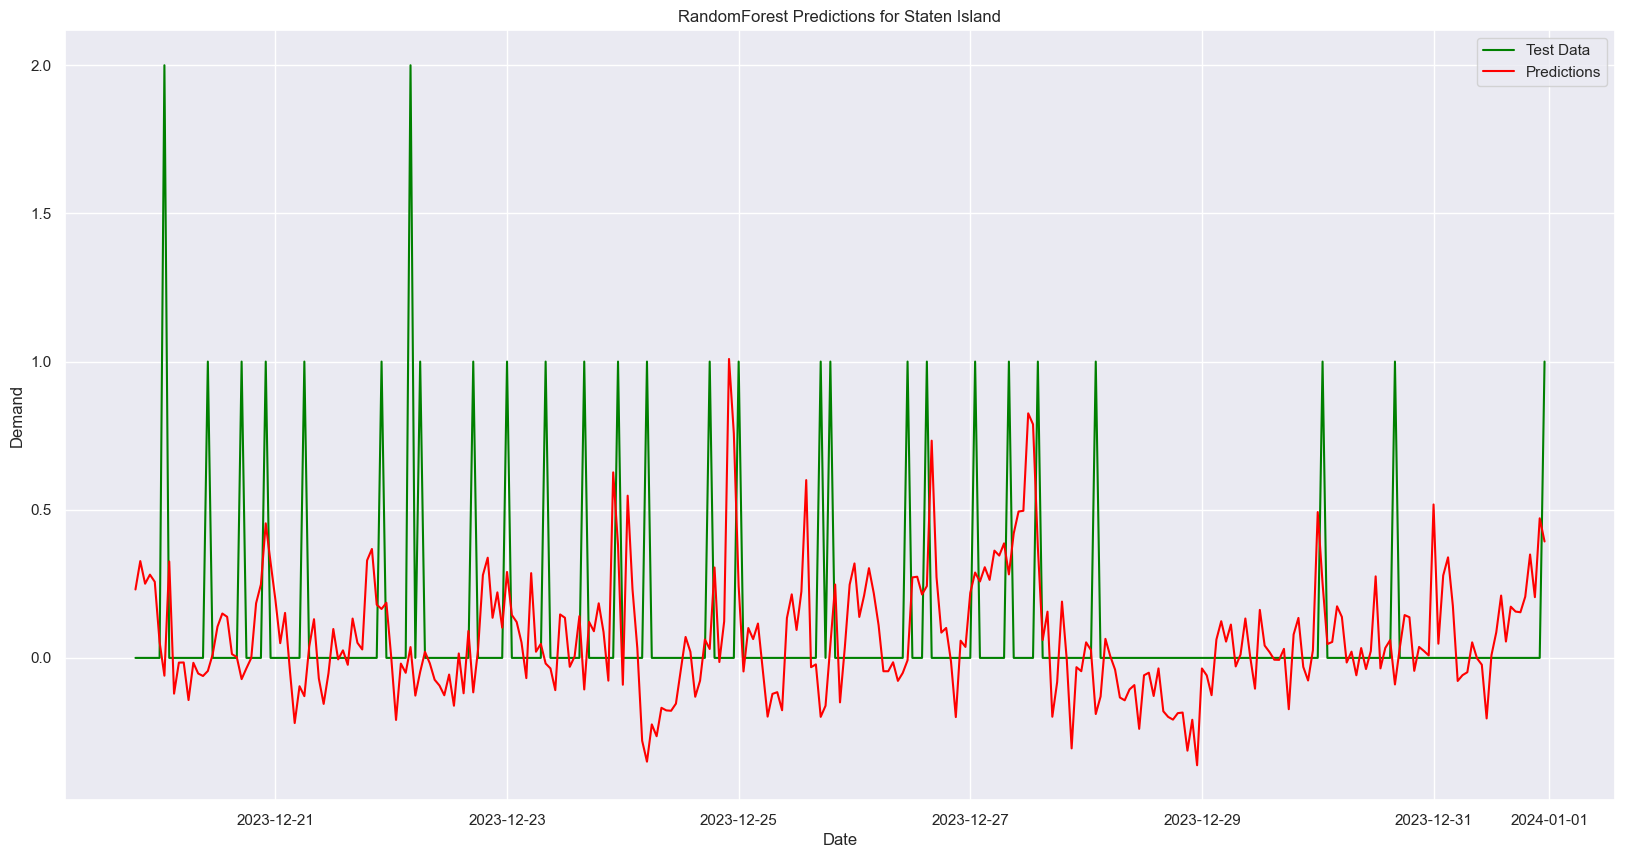

In [15]:
graficar_predicciones(predictions)